# Image Comparison in Biomedical image Analysis
> For the final chapter, you'll need to use your brain... and hundreds of others! Drawing data from more than 400 open-access MR images, you'll learn the basics of registration, resampling, and image comparison. Then, you'll use the extracted measurements to evaluate the effect of Alzheimer's Disease on brain structure. This is the Summary of lecture "Biomedical Image Analysis in Python", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Vision]
- image: 

In [1]:
import imageio
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

## Spatial transformations
- Registration
    - Align images to template
    - Minimize spatial variability
    - Templates:
        - May represent multiple subjects
        - May be an "average" image
    - Entails many spatial transformations
- Affine transformation
![affine](image/Affine_transformation.png)

    - **translation**: shifting of an image along an axis
    - **rotation**: turn the image along a plane
    - **scaling**: increase/decrease the size of the image
    - **shearing**: shift the ends of an axis away from each other.

### Translations
In this chapter, we'll leverage data use data from the [Open Access Series of Imaging Studies](https://www.oasis-brains.org/) to compare the brains of different populations: young and old, male and female, healthy and diseased.

To start, center a single slice of a 3D brain volume (im). First, find the center point in the image array and the center of mass of the brain. Then, translate the image to the center.

In [2]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. 
    Operations include: 
    1. Looping through `fig.axes` and turning off axis grid.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Find image center of mass
com = ndi.center_of_mass(im)

# Calculate amount of shift needed
d0 = 128 - com[0]
d1 = 128 - com[1]

# Translate the brain towards the center
xfm = ndi.shift(im, shift=(d0, d1))

# Plot the original and adjusted images
fig, axes = plt.subplots(2, 1)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()

### Rotations
In cases where an object is angled or flipped, the image can be rotated. Using `ndi.rotate()`, the image is rotated from its center by the specified degrees from the right horizontal axis.
![rotate](image/Ch4_L1_Rotated-Head.png)

For this exercise, shift and rotate the brain image (`im`) so that it is roughly level and "facing" the right side of the image.




In [ ]:
# Shift the image towards the center
xfm = ndi.shift(im, shift=(-20, -20))

# Rotate the shifted image
xfm = ndi.rotate(xfm, angle=-30, reshape=False)

# Plot the original and rotated images
fig, axes = plt.subplots(2, 1)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()

The order of transformations makes a difference: rotating the image first will alter the object center, changing the amount of shift needed.

### Affine transform
An affine transformation matrix provides directions for up to four types of changes: translating, rotating, rescaling and shearing. The elements of the matrix map the coordinates from the input array to the output.

![affine](image/Ch4_L3_Transformations.png)



To implement matrix transformations in your workflow, you will likely want to use more advanced tools, such as those in scikit-image. The package's website has some [nice tutorials](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_geometric.html). Also, note that 3D images require different size transformation matrices.

## Resampling and interpolation
- Resampling changes the array shape
![resample](image/resampling.png)
- Upsampling
    - Resampling to a larger grid
    - Not the same as collecting higher-resolution data
    - Useful for standardizing sampling rates that are unequal
- Interpolation
    - "Stitches together" grid points to model the space between points
    - **nearest-neighbor**:uses the closest measured value.(order = 0)
    - **b-spline interpolation**: models space between points with spline functions of a specified order (order is between 1 and 5)

### Resampling
Images can be collected in a variety of shapes and sizes. Resampling is a useful tool when these shapes need to be made consistent. Two common applications are:

- **Downsampling**: combining pixel data to decrease size
- **Upsampling**: distributing pixel data to increase size

For this exercise, transform and then resample the brain image (`im`) to see how it affects image shape.

In [ ]:
# Center and level image
xfm = ndi.shift(im, shift=(-20, -20))
xfm = ndi.rotate(xfm, angle=-35, reshape=False)

# Resample image
im_dn = ndi.zoom(xfm, zoom=0.25)
im_up = ndi.zoom(xfm, zoom=4)

# Plot the image
fig, axes = plt.subplots(2, 1)
axes[0].imshow(im_dn)
axes[1].imshow(im_up)
format_and_render_plots()

### Interpolation
Interpolation is how new pixel intensities are estimated when an image transformation is applied. It is implemented in SciPy using [sets of spline functions](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html).

Editing the interpolation `order` when using a function such as `ndi.zoom()` modifies the resulting estimate: higher orders provide more flexible estimates but take longer to compute.

For this exercise, upsample `im` and investigate the effect of different interpolation orders on the resulting image.

In [ ]:
# Upsample "im" by a factor of 4
up0 = ndi.zoom(im, zoom=4, order=0)
up5 = ndi.zoom(im, zoom=4, order=5)

# Print original and new shape
print('Original shape:', im.shape)
print('Upsampled shape:', up0.shape)

# Plot close-ups of the new images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(up0[128:256, 128:256])
axes[1].imshow(up5[128:256, 128:256])
format_and_render_plots()

The key trade-off is that more complex interpolation methods require greater computational resources. This can take a heavy toll when analyzing 3D volumes.

## Comparing images
- Intersection of the union
$$ IOU = \frac{I_1 \cap l_2}{I_1 \cup I_2} $$


### Mean absolute error
Cost functions and objective functions output a single value that summarizes how well two images match.

The **mean absolute error** (MAE), for example, summarizes intensity differences between two images, with higher values indicating greater divergence.

For this exercise, calculate the mean absolute error between `im1` and `im2` step-by-step.

In [3]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises.'''

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig = plt.gcf()
    ax = fig.axes[0]
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ax.get_images()[0], cax=cax)
    plt.show()

In [ ]:
# Calculate image difference
err = im1 - im2

# Plot the difference
plt.imshow(err, cmap='seismic', vmin=-200, vmax=200)
format_and_render_plot()

In [ ]:
# Calculate absolute image difference
abs_err = np.abs(im1 - im2)

# Plot the difference
plt.imshow(abs_err, cmap='seismic', vmin=-200, vmax=200)
format_and_render_plot()

In [ ]:
# Calculate mean absolute error
mean_abs_err = np.mean(np.abs(im1 - im2))
print('MAE:', mean_abs_err)

The MAE metric allows for variations in weighting throughout the image, which gives areas with high pixel intensities more influence on the cost calculation than others.

## Normalizing measurements
- Hypothesis testing
    - Null hypothesis: two populations' mean brain volumes ($\mu_m, \mu_w$) are equal.
    
$$ H_{null}: \mu_w = \mu_m \\ H_{alt} : \mu_w \neq \mu_m \\ t = \frac{\bar{X} - \mu}{\frac{s}{\sqrt{n}}}   $$

### Identifying potential confounds
Once measures have been extracted, double-check for dependencies within your data. This is especially true if any image parameters (sampling rate, field of view) might differ between subjects, or you pull multiple measures from a single image.

For the final exercises, we have combined demographic and brain volume measures into a pandas DataFrame (`df`).

First, you will explore the table and available variables. Then, you will check for correlations between the data.

In [9]:
import pandas as pd
df = pd.read_csv('./dataset/oasis_all_volumes.csv', index_col='ID')[['age', 
                                                                     'sex', 
                                                                     'alzheimers', 
                                                                     'brain_vol', 
                                                                     'skull_vol']]
df.head()

,age,sex,alzheimers,brain_vol,skull_vol
ID,,,,,
OAS1_0001_MR1,74,F,False,807.935,1347.497879
OAS1_0002_MR1,55,F,False,808.760,1151.269287
OAS1_0003_MR1,73,F,True,860.255,1403.415054
OAS1_0004_MR1,28,M,False,1058.202,1593.284910
OAS1_0005_MR1,18,M,False,1263.391,1733.779281


In [10]:
# Print random sample of rows
print(df.sample(3))

# Print prevalence of Alzheimer's Disease
print(df['alzheimers'].value_counts())

# Print a correlation table
print(df.corr())

               age sex  alzheimers  brain_vol    skull_vol
ID                                                        
OAS1_0319_MR1   31   M       False   1087.585  1584.562168
OAS1_0350_MR1   21   M       False   1198.931  1615.906633
OAS1_0349_MR1   43   F       False    933.523  1400.255991
False    332
True      93
Name: alzheimers, dtype: int64
                 age  alzheimers  brain_vol  skull_vol
age         1.000000    0.542463  -0.719211  -0.141576
alzheimers  0.542463    1.000000  -0.446771   0.014222
brain_vol  -0.719211   -0.446771   1.000000   0.654829
skull_vol  -0.141576    0.014222   0.654829   1.000000


### Testing group differences
Let's test the hypothesis that Alzheimer's Disease is characterized by reduced brain volume.
![test](image/Ch4_L4_Alzheimers-Typical.png)

We can perform a **two-sample t-test** between the brain volumes of elderly adults with and without Alzheimer's Disease. In this case, the two population samples are independent from each other because they are all separate subjects.

For this exercise, use the OASIS dataset (`df`) and `ttest_ind` to evaluate the hypothesis.

t =  -10.270763061696771
p =  3.0435503446584287e-22


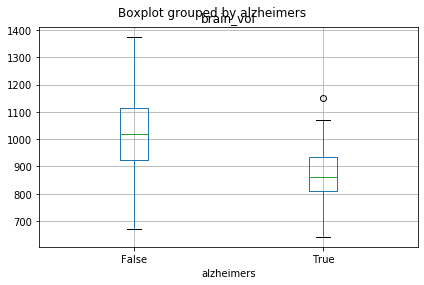

In [13]:
from scipy.stats import ttest_ind

# Select data from 'alzheimers' and 'typical' groups
brain_alz = df.loc[df.alzheimers == True, 'brain_vol']
brain_typ = df.loc[df.alzheimers == False, 'brain_vol']

# Perform t-test of "alz" > "typ"
results = ttest_ind(brain_alz, brain_typ)
print('t = ', results.statistic)
print('p = ', results.pvalue)

# Show boxplot of brain_vol difference
df.boxplot(column='brain_vol', by='alzheimers');
plt.tight_layout();

There is some evidence for decreased brain volume in individuals with Alzheimer's Disease. Since the p-value for this t-test is greater than 0.05, we would not reject the null hypothesis that states the two groups are equal.

### Normalizing metrics
We previously saw that there was not a significant difference between the brain volumes of elderly individuals with and without Alzheimer's Disease.

But could a correlated measure, such as "skull volume" be masking the differences?

For this exercise, calculate a new test statistic for the comparison of brain volume between groups, after adjusting for the subject's skull size.

Using `results.statistic` and `results.pvalue` as your guide, answer the question: Is there strong evidence that Alzheimer's Disease is marked by smaller brain size, relative to skull size?

In [14]:
# Divide 'df.brain_vol' by 'df.skull_vol'
df['adj_brain_vol'] = df['brain_vol'] / df['skull_vol']

# Select brain measures by Alzheimers group
brain_alz = df.loc[df.alzheimers == True, 'adj_brain_vol']
brain_typ = df.loc[df.alzheimers == False, 'adj_brain_vol']

# Evaluate null hypothesis
results = ttest_ind(brain_alz, brain_typ)
print('t = ', results.statistic)
print('p = ', results.pvalue)

t =  -15.311391823926563
p =  2.0192860861212413e-42
